In [1]:
import scipy.integrate as integrate
from scipy.stats import norm
from scipy.stats import t
import pandas as pd
import numpy as np
import math

S0 = 162.452
K = 160
Y = 5/252
r = 0.05

In [2]:
def calculate_parameters():
    historical_data = pd.read_csv("data_ALL/historical_data.csv")
    log_returns = np.log(historical_data['Last']/historical_data['Last'].shift(1))
    log_returns.dropna(inplace=True)
    sigma_std = np.std(log_returns)
    nu, mu, delta = t.fit(log_returns)
    delta = math.sqrt(delta*252)
    return nu, mu, delta

nu, mu, delta = calculate_parameters()
print("nu = " + str(nu))
print("mu = " + str(mu))
print("delta = " + str(delta))

nu = 12.122281271175913
mu = -0.001771446205980524
delta = 3.123328498823122


In [3]:
def d1_cdf(Y, K, S0, sigma, r, t):
    d1 = (math.log(S0/K) + r*Y + 0.5*sigma*sigma*t)/(sigma*math.sqrt(t))
    return norm.cdf(d1)

In [4]:
def d2_cdf(Y, K, S0, sigma, r, t):
    d2 = (math.log(S0/K) + r*Y - 0.5*sigma*sigma*t)/(sigma*math.sqrt(t))
    return norm.cdf(d2)

In [5]:
def fty(Y, nu, delta, t):
    a = (delta*delta)/2
    b = nu/2
    E = (delta*delta)/(nu-2)
    x = (t - E*(math.sqrt(Y) - Y)) / math.sqrt(Y)
    if x <= 0:
        return 0
    else:
        return (math.pow(a,b) / math.gamma(b)) * (x**(-b-1)) * (math.exp(-(a/x)))

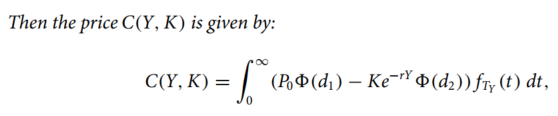

In [6]:
def option_price(Y, K, S0, d1_cdf, d2_cdf, r, nu, delta, sigma):
    def expr(t):
        d1_t = d1_cdf(Y, K, S0, sigma, r, t)
        d2_t = d2_cdf(Y, K, S0, sigma, r, t)
        fty_t = fty(Y, nu, delta, t)
        return ((S0*d1_t - K*math.exp(-r*Y)*d2_t) * fty_t)
    return integrate.quad(expr, 0, np.inf)[0]

In [7]:
sigma = 0.98
print("sigma = " + str(sigma))

option_pricing = option_price(Y, K, S0, d1_cdf, d2_cdf, r, nu, delta, sigma)
print("Option pricing = " + str(option_pricing))

sigma = 0.98
Option pricing = 4.5659619651987455


In [8]:
def monte_carlo(n, nu, delta, mu, S0, delta_t, teta, sigma, Y, K, r):
    mu_noise, sigma_noise = 0, 1
    white_noise_S = np.random.normal(mu_noise, sigma_noise, size = n)
    
    p_t = option_price(Y, K, S0, d1_cdf, d2_cdf, r, nu, delta, sigma)
    
    t_t = invgamma.rvs(scale=((delta*delta)/2), size=n, a=(nu/2))
    
    S_t_next = np.zeros(len(white_noise_S))
    for i in range(len(white_noise_S)):
        S_t_next[i] = S0 + mu*S0*(1/252) + S0*(teta + ((sigma**2)/2))*t_t[i] + sigma*math.sqrt(t_t[i])*white_noise_S[i]
        
    p_t_next = np.zeros(len(white_noise_S))
    for i in range(len(white_noise_S)):
        p_t_next[i] = option_price((Y - delta_t), K, S_t_next[i], d1_cdf, d2_cdf, r, nu, delta, sigma)
    
    p_t_diff = np.zeros(len(white_noise_S))
    for i in range(len(white_noise_S)):
        p_t_diff[i] = p_t_next[i] - p_t
        
    mc_table = pd.DataFrame({'S_(t+1)': S_t_next, 'p_(t+1)': p_t_next, 'p_(t+1) - p_t': p_t_diff})
    
    return mc_table

In [9]:
from scipy.stats import invgamma
teta = 0.01433
sigma = 0.958
S0 = 196
r = 0.05
teta = 0.01433
n = 1000
delta_t = 2/252
Y = 9/252
K = 195

mc = monte_carlo(n, nu, delta, mu, S0, delta_t, teta, sigma, Y, K, r)
mc

,S_(t+1),p_(t+1),p_(t+1) - p_t
0,334.006209,24.884737,16.820887
1,238.667889,11.566479,3.502629
2,285.110990,17.739581,9.675731
3,234.186478,11.014824,2.950973
4,353.242480,27.815664,19.751814
...,...,...,...
995,256.250901,13.812861,5.749011
996,309.767027,21.279122,13.215272
997,329.240092,24.167387,16.103536
998,275.028112,16.337891,8.274040


In [15]:
def value_at_risk(data, alpha = 0.95):
    sorted_data = np.sort(data)
    VaR = np.quantile(data, alpha)
    return VaR

VaR = value_at_risk(mc['p_(t+1) - p_t'])
VaR

20.997153215820482